In [1]:
from models.nn import SigmoidSiameseNetwork, ContrastiveSiameseNetwork

from imutils import paths
from PIL import Image
import numpy as np
import plot
import os

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils
import torchvision

import torch
import torch.nn.functional as F

In [2]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

# load the model
model = SigmoidSiameseNetwork().to(device)
model.load_state_dict(torch.load('checkpoints/sigmoid_siamese.pth'))
model.eval()

Device: cuda


SigmoidSiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [4]:
# path to the LFW dataset
lfw_dataset = 'lfw/'

# get paths to all images in the LFW dataset
imgPaths = list(paths.list_images(lfw_dataset))

# total number images
print(len(imgPaths))

12000


In [5]:
# create two dictionaries to store positive and negative pairs
pos_pairs = {}
neg_pairs = {}

for imgPath in imgPaths:
    main_folder, pair_type, img_folder, img_name = imgPath.split('/')
    path_to_pair = os.path.join(main_folder, pair_type, img_folder)
    if pair_type == 'positive': 
        if path_to_pair not in pos_pairs:
            pos_pairs[path_to_pair] = [imgPath]
        else:
            pos_pairs[path_to_pair].append(imgPath)
    else:
        if path_to_pair not in neg_pairs:
            neg_pairs[path_to_pair] = [imgPath]
        else:
            neg_pairs[path_to_pair].append(imgPath)

In [6]:
# image transformation 
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor()])

def img_process(img_path, transform, device):
    img = Image.open(img_path)
    img = img.convert("L")
    img = transform(img)
    img = torch.unsqueeze(img,dim=1)
    img = img.to(device)
    
    return img

In [7]:
# define lists to store true labels, predicted labels, and scores
y_true = []
y_pred = []
scores = []

# threshold to cut predictions with lower scores
threshold = 0.5

# function that measures cosine similary
Cosine_Similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

# pass positive and negative pairs through the model
# and calculate cosine distance using output embeddings
with torch.no_grad():
    for img1_path, img2_path in pos_pairs.values():
        img1 = img_process(img1_path, transform, device)
        img2 = img_process(img2_path, transform, device)
        output1, output2 = model.forward_once(img1), model.forward_once(img2)
        euclidean_distance = F.pairwise_distance(output1.flatten(), output2.flatten())
        cosine_similarity = Cosine_Similarity(output1, output2)
        cosine_distance = 1-cosine_similarity.cpu().detach().numpy()[0]
        y_true.append(1)
        scores.append(cosine_distance)
        if cosine_distance < threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)

    for img1_path, img2_path in neg_pairs.values():
        img1 = img_process(img1_path, transform, device)
        img2 = img_process(img2_path, transform, device)
        output1, output2 = model.forward_once(img1), model.forward_once(img2)
        euclidean_distance = F.pairwise_distance(output1.flatten(), output2.flatten())
        cosine_similarity = Cosine_Similarity(output1, output2)
        cosine_distance = 1-cosine_similarity.cpu().detach().numpy()[0]
        y_true.append(0)
        scores.append(cosine_distance)
        if cosine_distance < threshold:
            y_pred.append(1)
        else:
            y_pred.append(0)

In [8]:
from sklearn.metrics import confusion_matrix, classification_report

# calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# True Positives, True Negatives, False Positives, False Negatives
tn, fp, fn, tp = confusion.ravel()

# print the confusion matrix and classification report
print("Confusion Matrix:")
print(confusion)
print("\nTrue Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)

# print the classification report
report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[1929 1071]
 [ 131 2869]]

True Positives: 2869
True Negatives: 1929
False Positives: 1071
False Negatives: 131

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      3000
           1       0.73      0.96      0.83      3000

    accuracy                           0.80      6000
   macro avg       0.83      0.80      0.79      6000
weighted avg       0.83      0.80      0.79      6000



In [9]:
# calculate False Positive Rates, True Positive Rates, and Thresholds
fpr, tpr, thrs = roc_curve(y_true, scores, pos_label=0)

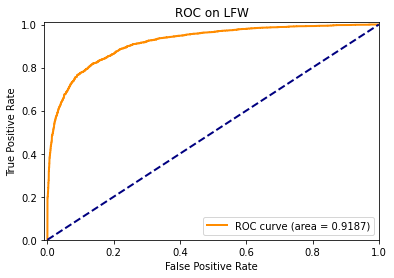

In [10]:
# Plot ROC curve
fig = plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on LFW')
plt.legend(loc="lower right")
plt.show()
fig.savefig("roc_lfw.png", dpi=fig.dpi)

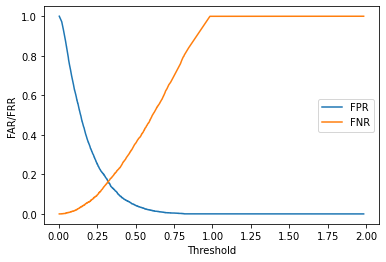

In [11]:
# plot fpr, tpr against the no. of threshold
# FAR = FPR = FP/(FP + TN)
# FRR = FNR = FN/(FN + TP)
fnr = 1 - tpr

fig = plt.figure()
plt.plot(thrs, fpr, label='FPR')
plt.plot(thrs, fnr, label='FNR')
plt.xlabel('Threshold')
plt.ylabel('FAR/FRR')
plt.legend()
plt.show()
fig.savefig("far_fpr_thr.png", dpi=fig.dpi)

In [12]:
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thrs)(eer)
print(f"EER: {eer*100:.2f}%")
print(f"Threshold: {thresh:.4f}")

EER: 16.33%
Threshold: 0.3216


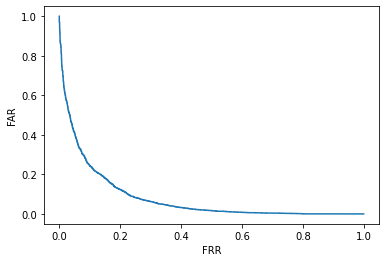

In [13]:
# plot fpr vs tpr
fnr = 1 - tpr

fig = plt.figure()
plt.plot(fnr, fpr)
plt.xlabel('FRR')
plt.ylabel('FAR')
plt.show()
fig.savefig("far_fpr.png", dpi=fig.dpi)